In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/weichen-ua/MIS_Python_Bootcamp/master/listings.csv")

In [ ]:
df.head()

,id,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,price,number_of_reviews_ltm,review_scores_rating,instant_bookable,reviews_per_month
0,5.366178e+07,62320777,95%,97%,t,7.0,Rancho Bernadino,33.095280,-117.108360,Private room,4,1 private bath,2.0,2.0,167,0,NaN,f,NaN
1,6.000000e+17,414789390,100%,100%,f,1.0,Tijuana River Valley,32.530662,-117.083151,Entire home/apt,6,1.5 baths,2.0,3.0,96,1,5.00,t,0.64
2,5.208888e+07,100368579,100%,94%,f,0.0,San Carlos,32.789742,-117.034927,Private room,2,1 private bath,1.0,1.0,85,7,4.71,f,3.62
3,6.290000e+17,95926933,100%,79%,f,2.0,Mission Bay,32.545208,-116.933914,Entire home/apt,4,1 bath,1.0,3.0,54,0,NaN,t,NaN
4,1.962131e+07,46170232,100%,98%,t,5.0,Mission Bay,33.085530,-117.027570,Private room,5,1 private bath,1.0,4.0,90,30,5.00,f,2.45


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df[df["host_is_superhost"]=="t"]["price"],
    histnorm='percent',
    name='t',
    xbins=dict(  # bins used for histogram
        start=0,
        end=500.0,
        size=10
    ),
    marker_color='#EB89B5',
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=df[df["host_is_superhost"] == "f"]["price"],
    histnorm='percent',
    name='f',
    xbins=dict(  # bins used for histogram
        start=0,
        end=500.0,
        size=10
    ),
    marker_color='#330C73',
    opacity=0.75
))

fig.update_layout(
    title_text='Airbnb Prices in San Diego',  # title of plot
    xaxis_title_text='Price',  # xaxis label
    yaxis_title_text='Count',  # yaxis label
    bargap=0.1,  # gap between bars of adjacent location coordinates
    bargroupgap=0.1  # gap between bars of the same location coordinates
)

fig.show()

In [ ]:
# Convert some columns
df['superhost'] = (df['host_is_superhost'] == 't')
df['instant_b'] = (df['instant_bookable'] == 't')
df['entire_home'] = (df['room_type'] == 'Entire home/apt')
df['private_room'] = (df['room_type'] == 'Private room')

df.loc[:5, ['superhost', 'instant_b', 'entire_home', 'private_room']]

,superhost,instant_b,entire_home,private_room
0,True,False,False,True
1,False,True,True,False
2,False,False,False,True
3,False,True,True,False
4,True,False,False,True
5,False,True,True,False


In [ ]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

df.fillna(0, inplace=True)
training_df = df.sample(frac=0.8, random_state=53)
validating_df = df.loc[~df['id'].isin(training_df['id'])].copy()

target_col = 'reviews_per_month'
feature_list = ['superhost', 'host_listings_count', 'instant_b', 'entire_home', 'private_room', 'accommodates', 'bedrooms', 'beds', 'review_scores_rating', 'price']

X = np.array(training_df.loc[:, feature_list])
Y = np.array(training_df[target_col])

xgbc = XGBRegressor(n_estimators=50, random_state=53)
X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=53)

# do the prediction with xgboost
print("Forecasting with xgboost regressor")
xgbc.fit(X_train, Y_train)
Y_hat_xgbc = xgbc.predict(X_test)

print(f'mean absolute error: {mean_absolute_error(Y_test, Y_hat_xgbc)}')
print(f'mean squared error: {mean_squared_error(Y_test, Y_hat_xgbc)}')

# Validate using the validation set
print("Validating with xgboost regressor")
Y_val = np.array(validating_df[target_col])
X_val = np.array(validating_df.loc[:, feature_list])
Y_hat_val = xgbc.predict(X_val)

print(f'mean absolute error: {mean_absolute_error(Y_val, Y_hat_val)}')
print(f'mean squared error: {mean_squared_error(Y_val, Y_hat_val)}')

Forecasting with xgboost regressor
[20:46:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
mean absolute error: 1.036916608017941
mean squared error: 2.1851335638160836
Validating with xgboost regressor
mean absolute error: 1.0701216307246053
mean squared error: 2.2405820536857415


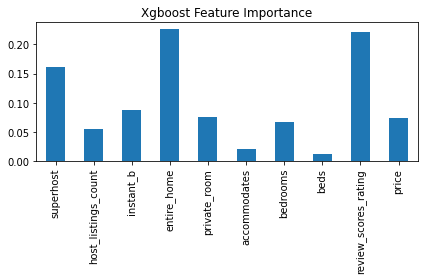

In [ ]:
# Examine feature importance

import matplotlib.pyplot as plt

xgb_importances = pd.Series(
    xgbc.feature_importances_, index=feature_list)

fig, ax = plt.subplots()
xgb_importances.plot.bar(ax=ax)
ax.set_title("Xgboost Feature Importance")
fig.tight_layout()

In [ ]:
df['reviews_per_month'].describe()

count    13272.000000
mean         1.722115
std          1.863843
min          0.000000
25%          0.250000
50%          1.050000
75%          2.670000
max         13.610000
Name: reviews_per_month, dtype: float64